# Dog Breed Classifier

## Convolutional Neural Networks

---
### The Goal 

The app developed here is code that will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays a potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

In a real-world setting, one would need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  This imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

I broke the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write The Algorithm
* [Step 7](#step7): Test The Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I import a dataset of dog images.  I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, I demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


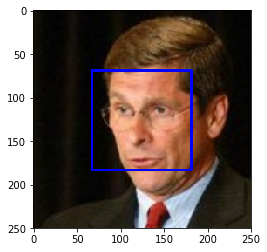

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

I can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  Assess the Human Face Detector

Ideally, I would like 100% of human images with a detected face and 0% of dog images with a detected face.  One will see that our algorithm falls short of this goal, but still gives acceptable performance.  I extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ I detect human faces in 100% of the human images (duh!), but still 11% in the dog pictures (i.e. 11 images out of the 100 are detecting a human face).

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
num_human_files = len(human_files_short)*1.0
num_human_faces = 0.0
for file in human_files_short:
    if face_detector(file): num_human_faces+=1.0;
print("Percentage of human faces detected: " + str(num_human_faces / num_human_files * 100.0))

num_train_files = len(dog_files_short)*1.0
num_train_faces = 0.0
for file in dog_files_short:
    if face_detector(file): num_train_faces+=1.0;
print("Percentage of dog 'faces' detected: " + str(num_train_faces / num_train_files * 100.0))

Percentage of human faces detected: 100.0
Percentage of dog 'faces' detected: 11.0


This algorithmic choice necessitates that I communicate to the user that I accept human images only when they provide a clear view of a face (otherwise, I risk having unneccessarily frustrated users!). So the question: Is this a reasonable expectation to pose on the user? If not, can I think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ That is in general of course not a good approach, since a human detection cannot simply rely on detecting a face. A self-driving car for example needs to be able to detect humans irrespective of whether there's a face detected or not.

However, since I try to find the closest dog breed for a given human, a face might be necessary to get a good result, otherwise the results may be too arbitrary. So my suggestion would be to strongly suggest to the user to give a facial image for good results, while it will still return the closest result for a non-face human image.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which I'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since I am working with color images, each image has three channels.  Likewise, since I am processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that there's a way to format our image for supplying to ResNet-50, I am now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, I obtain an integer corresponding to the model's predicted object class, which I can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), it's easy to notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, I need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

I use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

Let's assess the quality of the dog detector.

In [11]:
### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

detected_dogs = 0
detected_humans = 0
for file in human_files_short:
    if (dog_detector(file)): detected_humans+=1;
        
for file in dog_files_short:
    if (dog_detector(file)): detected_dogs+=1;
        
print( "Out of " + str(len(human_files_short)) +" human images, we detected " + str(detected_humans) + 
      " as being doges, that is "+ str(detected_humans/len(human_files_short)*100.0) + "% ." )
print( "Out of " + str(len(dog_files_short)) +" doge images, we detected " + str(detected_dogs) + 
      " as being doges, that is "+ str(detected_dogs/len(dog_files_short)*100.0) + "% ." )    

Out of 100 human images, we detected 0 as being doges, that is 0.0% .
Out of 100 doge images, we detected 100 as being doges, that is 100.0% .


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that I have functions for detecting humans and dogs in images, I need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds.  Later, I will instead use transfer learning to create a CNN that attains greatly improved accuracy, but for good training it's best to do it from scratch first.

First, I should be careful with adding too many trainable layers!  More parameters means longer training, which means I will be more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; I can extrapolate this estimate to figure out how long it will take for the algorithm to train. 

It's probably true that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  A vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

I should also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

The rule of thumb is: Experiment with many different architectures, and trust intuition.  And, of course, have fun! 

### Pre-process the Data

I rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.47it/s]


### Model Architecture

Time to create the CNN to classify dog breed.

The proposed architecture combines three convolution and three pooling layers, with increasing amount of filters towards the end of the architecture; followed by a Global Pooling Layer and a dense layer with softmax activation to give a probability for the total 133 doge races. 

This seems a very reasonable approach for image classification: I start with fewer filters at the beginning of the model when the images are still large, and increase the number of filters down the model when the pooling has reduced the size of the images. Three activation and three pooling layers are probably the minimum number of such layers for a model, but provide a good starting point. The other chosen configurations (Relu with Softmax at the end, Global Average Pooling before the final Dense layer) are also good "standard" choices. 

In summary, the model is a very classic approach to an image classification problem.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Defining the architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D(input_shape=(4, 4, 64)))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

###  Train the Model

I use model checkpointing to save the model that attains the best validation loss.

In [15]:
from keras.callbacks import ModelCheckpoint  

### Specify the number of epochs to train the model.

epochs = 10

### Use checkpointing

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8802 - acc: 0.0100 - val_loss: 4.8609 - val_acc: 0.0144
Epoch 2/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8427 - acc: 0.0153 - val_loss: 4.8312 - val_acc: 0.0192
Epoch 3/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8049 - acc: 0.0160 - val_loss: 4.8024 - val_acc: 0.0192
Epoch 4/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7763 - acc: 0.0174 - val_loss: 4.7840 - val_acc: 0.0180
Epoch 5/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7494 - acc: 0.0204 - val_loss: 4.7663 - val_acc: 0.0192
Epoch 6/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.7239 - acc: 0.0240 - val_loss: 4.7449 - val_acc: 0.0240
Epoch 7/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6983 - acc: 0.0284 - val_loss: 4.7343 - val_acc: 0.0263
Epoch 8/

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Let's try out the model on the test dataset of dog images. I should reach a test accuracy is greater than 1% (hopefully!)

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.1100%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, it's time to train a CNN using transfer learning.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  I only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 293us/step - loss: 12.5580 - acc: 0.1162 - val_loss: 11.0555 - val_acc: 0.2060
Epoch 2/20
6680/6680 [==============================] - 2s 249us/step - loss: 10.4766 - acc: 0.2596 - val_loss: 10.4824 - val_acc: 0.2575
Epoch 3/20
6680/6680 [==============================] - 2s 248us/step - loss: 9.9870 - acc: 0.3220 - val_loss: 10.2205 - val_acc: 0.3030
Epoch 4/20
6680/6680 [==============================] - 2s 249us/step - loss: 9.7945 - acc: 0.3475 - val_loss: 9.9860 - val_acc: 0.3102
Epoch 5/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.5123 - acc: 0.3713 - val_loss: 9.8626 - val_acc: 0.3269
Epoch 6/20
6680/6680 [==============================] - 2s 242us/step - loss: 9.2937 - acc: 0.3919 - val_loss: 9.6489 - val_acc: 0.3377
Epoch 7/20
6680/6680 [==============================] - 2s 244us/step - loss: 9.1636 - acc: 0.4078 - val_loss: 9.5703 - val_acc: 0.3

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, I can use the CNN to test how well it identifies breed within our test dataset of dog images.  I print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.4306%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.  The CNN should attain at least 60% accuracy on the test set.

In Step 4, I used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I will use the bottleneck features from a different pre-trained model.  To make things easier, I have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  For the purposes of this exemplary notebook, I will pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features


In [25]:
### Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']


###  Model Architecture

Now onto creating a CNN to classify dog breeds.

Just as before, I am using transfer learning by using a pre-trained CNN to improve the accuracy by using its pre-trained weights. I use the initial layers of the model and add a final pooling layer and a fully-connected layer resulting in a softmax prediction for the 133 breeds. Resnet50 should give good results for our image classification problem.



In [26]:
### Define the architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


###  Compile the Model

In [27]:
### Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Once again, I am using model checkpointing to save the model that attains the best validation loss.

In [28]:
### Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 258us/step - loss: 1.6082 - acc: 0.6043 - val_loss: 0.7721 - val_acc: 0.7665
Epoch 2/20
6680/6680 [==============================] - 1s 214us/step - loss: 0.4351 - acc: 0.8632 - val_loss: 0.7572 - val_acc: 0.7617
Epoch 3/20
6680/6680 [==============================] - 1s 213us/step - loss: 0.2646 - acc: 0.9174 - val_loss: 0.6799 - val_acc: 0.7952
Epoch 4/20
6680/6680 [==============================] - 1s 212us/step - loss: 0.1767 - acc: 0.9493 - val_loss: 0.6826 - val_acc: 0.8000
Epoch 5/20
6680/6680 [==============================] - 1s 213us/step - loss: 0.1239 - acc: 0.9612 - val_loss: 0.6901 - val_acc: 0.8024
Epoch 6/20
6680/6680 [==============================] - 1s 213us/step - loss: 0.0905 - acc: 0.9726 - val_loss: 0.7001 - val_acc: 0.8108
Epoch 7/20
6680/6680 [==============================] - 1s 211us/step - loss: 0.0682 - acc: 0.9798 - val_loss: 0.7300 - val_acc: 0.8108
E

### Load the Model with the Best Validation Loss

In [29]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Let's try out the model on the test dataset of dog images. It should reach a test accuracy of at least 60%.

In [30]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.3493%


### Predict a Dog Breed with the Model

Here, I write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, the function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to the chosen CNN architecture, I can to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
### Writing a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write the final Algorithm

Finally, I write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

For this, I will make use of the `face_detector` and `dog_detector` functions developed above.

![Sample Human Output](images/sample_human_output.png)


###  Write the Algorithm

In [32]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def checkImage(img_path):
    if dog_detector(img_path): return 'dog';
    if face_detector(img_path): return 'human';
    return 'fail';

def predictBreed(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if checkImage(img_path)=='dog':
        print("Wow, such cute doge. Let's see if I can find breed ...")
        plt.imshow(cv_rgb)
        plt.show()
        print("Methinks your breed is ...")
        print( Resnet50_predict_breed(img_path) )
        print("-------------------------")
    
    elif checkImage(img_path)=='human':
        print("Hello, Human!")
        plt.imshow(cv_rgb)
        plt.show()
        print("You look like a ...")
        print( Resnet50_predict_breed(img_path) )
        print("\n")
        print("-------------------------")
    
    else: 
        print("Neither a dog nor a human was detected in the provided image. Aborting.")
        plt.imshow(cv_rgb)
        plt.show()
        print("-------------------------")

---
<a id='step7'></a>
## Step 7: Test The Algorithm

Besides feeding images of human faces and dogs to the machine, I will also supply some difficult images as well to see if I can fool the algorithm.

### Test The Algorithm on Sample Images
 
The output is actually pretty good. It even avoided the cat. Points of improvement could be:

(1) Train more so that accuracy achieves at least 90%
(2) Improve detection algorithm so that false positives get reduced
(3) Use augmented data so that rotated or otherwise distorted images get detected

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Hello, Human!


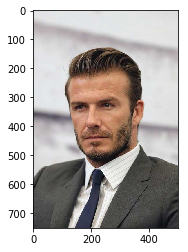

You look like a ...
94658560/94653016 [==============================] - 1s 0us/step
English_springer_spaniel


-------------------------
Neither a dog nor a human was detected in the provided image. Aborting.


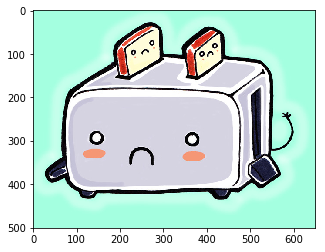

-------------------------
Neither a dog nor a human was detected in the provided image. Aborting.


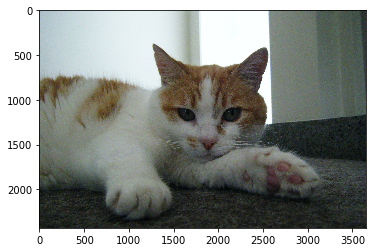

-------------------------
Hello, Human!


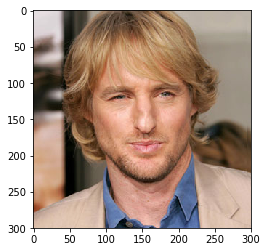

You look like a ...
Silky_terrier


-------------------------
Wow, such cute doge. Let's see if I can find breed ...


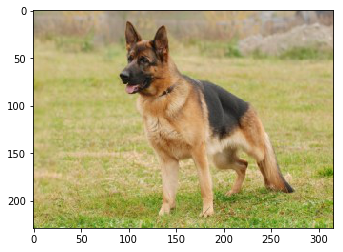

Methinks your breed is ...
German_shepherd_dog
-------------------------
Wow, such cute doge. Let's see if I can find breed ...


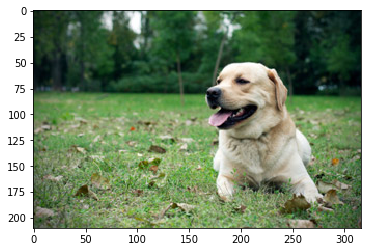

Methinks your breed is ...
Golden_retriever
-------------------------
Hello, Human!


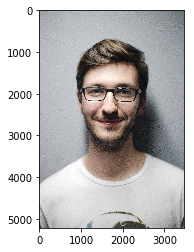

You look like a ...
Chihuahua


-------------------------
Wow, such cute doge. Let's see if I can find breed ...


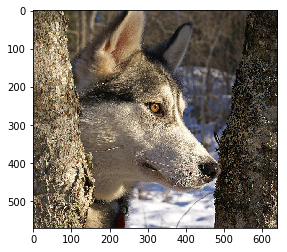

Methinks your breed is ...
Alaskan_malamute
-------------------------
Wow, such cute doge. Let's see if I can find breed ...


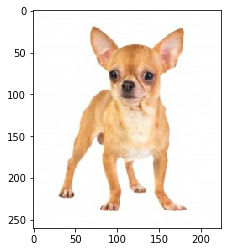

Methinks your breed is ...
Chihuahua
-------------------------


In [34]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
images = np.array(glob("images_sub/*"))
random.shuffle(images)

for img in images:
    predictBreed(img)